In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from scipy import interp
from itertools import cycle

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc


### Read in Dataset and Preprocess

In [2]:
students_df = pd.read_csv("train.csv", parse_dates=[2,3,9])

In [3]:
students_df.head()

,ID,Salary,DOJ,DOL,Original Designation,Designation,Domain,JobCity,Gender,DOB,10percentage,10board,12graduation,12percentage,12board,CollegeID,CollegeTier,Degree,Specialization,collegeGPA,CollegeCityID,CollegeCityTier,CollegeState,GraduationYear,English,Logical,Quant,DomainScore,ComputerProgramming,ElectronicsAndSemicon,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience
0,42418,435000.0,2010-05-01,2014-06-01,electrical engineer,electrical engineer,Engineering,Bhopal,f,1987-10-23,65.0,cbse,2005,54.0,cbse,402,1,B.Tech/B.E.,biomedical engineering,65.90,402,0,Madhya Pradesh,2010,405,425,405,0.0,0,0,0,0,0,0,0,0.9737,-0.2793,-1.2148,-0.8778,0.5024
1,214964,315000.0,2011-08-01,2012-07-01,senior software engineer,senior software engineer,Engineering,Mumbai,f,1988-12-25,88.4,cbse,2006,79.2,cbse,332,1,B.Tech/B.E.,biomedical engineering,69.54,332,0,Punjab,2011,525,705,524,0.0,0,0,0,0,0,0,0,0.9737,-0.1232,-1.0697,1.5899,0.9763
2,900218,420000.0,2010-07-01,2011-08-01,management trainee,trainee manager,Management,NCR,m,1988-01-11,82.0,cbse,2005,75.8,cbse,443,1,M.Tech./M.E.,other,82.50,443,0,Uttar Pradesh,2014,625,520,705,0.0,0,0,0,0,0,0,0,-1.8825,0.5454,-0.9122,-0.1076,-1.4356
3,220655,400000.0,2011-06-01,2013-03-01,team leader,technical lead,Management,Chandigarh,m,1989-11-16,88.2,cbse,2007,77.8,cbse,285,1,B.Tech/B.E.,chemical engineering,62.40,285,0,Punjab,2011,595,695,575,0.0,0,0,0,0,0,0,0,-1.0355,0.9688,-0.6343,-0.4078,0.0284
4,962376,700000.0,2014-07-01,NaT,product manager,product manager,Management,Jaipur,m,1992-01-03,87.4,cbse,2009,74.0,state board,436,1,M.Tech./M.E.,other,72.79,436,0,Uttarakhand,2014,625,450,655,0.0,0,0,0,0,0,0,0,-0.3027,-0.4536,-0.6048,-0.8682,0.0973


Convert categorical data into codes for ML input

In [4]:
students_df['Gender'] = students_df['Gender'].map( {'f': 0,
                                                    'm': 1} )

In [4]:
students_df['Specialization'] = students_df['Specialization'].astype('category')
students_df['SpecializationC'] = students_df['Specialization'].cat.codes

In [8]:
students_df['Specialization']

0        biomedical engineering
1        biomedical engineering
2                         other
3          chemical engineering
4                         other
5          chemical engineering
6             civil engineering
7             civil engineering
8       electronics engineering
9             civil engineering
10         chemical engineering
11             computer science
12            civil engineering
13      electronics engineering
14       information technology
15             computer science
16       electrical engineering
17         computer application
18      electronics engineering
19       mechanical engineering
20            civil engineering
21      electronics engineering
22      electronics engineering
23            civil engineering
24       mechanical engineering
25       biomedical engineering
26             computer science
27             computer science
28       biomedical engineering
29             computer science
                 ...           
3958    

In [6]:
students_df['Degree'] = students_df['Degree'].astype('category')
students_df['DegreeC'] = students_df['Degree'].cat.codes

In [7]:
students_df['12board'] = students_df['12board'].astype('category')
students_df['12boardC'] = students_df['12board'].cat.codes

In [8]:
students_df['10board'] = students_df['10board'].astype('category')
students_df['10boardC'] = students_df['10board'].cat.codes

In [9]:
students_df['Domain'] = students_df['Domain'].astype('category')
students_df['DomainC'] = students_df['Domain'].cat.codes

In [10]:
students_df.DOB = 2017 - students_df.DOB.dt.year
students_df.DOJ = students_df.DOJ.dt.year
students_df.DOL = students_df.DOL.dt.year

Consider cities which have enough records to train (>10)

In [11]:
students_df.groupby(['JobCity']).size().nlargest(20).reset_index(drop=False)

,JobCity,0
0,NCR,909
1,Banagalore,687
2,Hyderabad,373
3,Pune,328
4,Chennai,315
5,Mumbai,161
6,Kolkata,120
7,Jaipur,53
8,Chandigarh,44
9,Lucknow,41


In [12]:
students_filtered_df = students_df[students_df.JobCity.isin(list(students_df.groupby(['JobCity']).size().nlargest(20).reset_index(drop=False)['JobCity']))]
                                

In [13]:
print("Total records: {} New total records after filtering on JobCity: {}".format(len(students_df), len(students_filtered_df)))

Total records: 3988 New total records after filtering on JobCity: 3249


In [14]:
students_filtered_df['JobCity'] = students_filtered_df['JobCity'].astype('category')
students_filtered_df['JobCityC'] = students_filtered_df['JobCity'].cat.codes

/Users/rohitraghavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/rohitraghavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Feature Selection

In [15]:
#DomainC being a categorical var, shouldn't use Pearson's correlation.
students_filtered_corr = pd.DataFrame(students_filtered_df.corr()['DomainC'])
students_filtered_corr.columns = ['Correlation']
students_filtered_corr['AbsCorrelation'] = students_filtered_corr['Correlation'].abs()
students_filtered_corr = students_filtered_corr.sort_values(by='AbsCorrelation', ascending=False)
students_filtered_corr.iloc[1:len(students_filtered_corr)-1, :1]

,Correlation
MechanicalEngg,0.079297
Quant,-0.079118
Salary,-0.075744
Logical,-0.071384
collegeGPA,-0.067256
SpecializationC,0.055716
Gender,-0.052078
ComputerProgramming,-0.046325
DomainScore,-0.045509
openess_to_experience,0.039064


In [16]:
clf = DecisionTreeClassifier()
clf.fit(students_filtered_df.drop(['DomainC','Domain','ID','DOL','Original Designation','Designation','JobCity','10board','12board','Degree','Specialization','CollegeState'], axis=1),students_filtered_df['DomainC'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

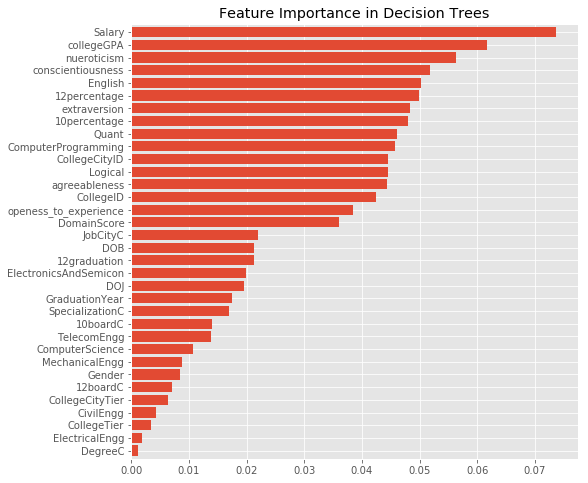

In [17]:
f,ax=plt.subplots(1,1,figsize=(8,8))
pd.Series(clf.feature_importances_,students_filtered_df.drop(['DomainC','Domain','ID','DOL','Original Designation','Designation','JobCity','10board','12board','Degree','Specialization','CollegeState'], axis=1).columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax)
ax.set_title('Feature Importance in Decision Trees')
plt.show()

In [32]:
X = students_filtered_df[['JobCityC', 'Salary', 'Quant', 'Logical', 'English', 'conscientiousness', 'agreeableness', 'extraversion', 'nueroticism', 'openess_to_experience', 'collegeGPA', '10percentage', '12percentage', 'DomainScore', 'ComputerProgramming', 'SpecializationC', 'DegreeC', 'CollegeTier']]
#X = pd.concat([X, pd.get_dummies(students_filtered_df["JobCityC"])], axis=1)
#X = pd.concat([X, pd.get_dummies(students_filtered_df["SpecializationC"])], axis=1)
#X = pd.concat([X, pd.get_dummies(students_filtered_df["DegreeC"])], axis=1)
#X = pd.concat([X, pd.get_dummies(students_filtered_df["CollegeTier"])], axis=1)
Y = students_filtered_df[['DomainC']]

Split into train/test

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [34]:
X_train['DomainC'] = Y_train['DomainC']

/Users/rohitraghavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Upsample based on Domain

In [35]:
X_train_ = list()
X_train_upsampled_ = list()
X_train_upsampled = pd.DataFrame()
max_samples = list(X_train.groupby(['DomainC']).size().nlargest(1))[0]
for i in set(X_train.DomainC):
    X_train_.append(X_train[X_train.DomainC==i])
    X_train_upsampled_.append(resample(X_train_[i], replace=True, n_samples=max_samples, random_state=123))
    X_train_upsampled = pd.concat([X_train_upsampled, X_train_upsampled_[i]])
# Display new class counts
X_train_upsampled.groupby(['DomainC']).size().nlargest(15)


DomainC
0     1556
1     1556
2     1556
3     1556
4     1556
5     1556
6     1556
7     1556
8     1556
9     1556
10    1556
11    1556
12    1556
13    1556
dtype: int64

In [36]:
Y_train = X_train_upsampled['DomainC']
X_train = X_train_upsampled.drop('DomainC', axis=1)

In [37]:
X_train.head()

,JobCityC,Salary,Quant,Logical,English,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience,collegeGPA,10percentage,12percentage,DomainScore,ComputerProgramming,SpecializationC,DegreeC,CollegeTier
3098,1,300000.0,575,580,580,1.2772,1.5444,1.2396,-1.5021,-0.6692,79.00,79.00,71.00,0.486747,565,4,0,2
1271,17,390000.0,495,655,485,0.9900,1.3779,1.2396,-0.2344,-0.2859,82.70,82.00,70.00,0.000000,525,8,0,2
2528,17,500000.0,885,560,710,0.1282,0.2124,0.1637,-0.4879,0.4805,94.60,95.20,91.40,0.824666,445,5,0,1
2280,4,100000.0,380,590,500,-0.8772,0.2124,0.6248,-0.7415,-0.0943,63.00,82.00,59.00,0.649390,0,6,0,2
2002,18,305000.0,705,545,695,-1.6538,0.6568,-0.9245,1.3549,0.1864,55.55,73.33,57.67,0.376060,0,6,0,1


### Modeling

In [38]:
#ovrc = OneVsRestClassifier(LinearSVC(random_state=0, class_weight='balanced'))
ovrc = OneVsRestClassifier(RandomForestClassifier())
Y_pred = ovrc.fit(X_train, Y_train).predict(X_test)

In [39]:
pd.DataFrame(confusion_matrix(Y_pred, Y_test))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,23,4,592,1,14,21,2,8,41,6,4,18,77,35
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,2,0,0,1,0,0,0,0,0,0,3,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,0,0,14,0,1,0,0,1,1,0,0,0,2,2
9,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [40]:
print("Accuracy: {}".format(accuracy_score(Y_pred, Y_test)))

Accuracy: 0.6205128205128205


In [41]:
domain_categories = dict(enumerate(students_filtered_df['Domain'].cat.categories))
domain_categories

{0: 'Business',
 1: 'Education',
 2: 'Engineering',
 3: 'Finance',
 4: 'HR',
 5: 'Management',
 6: 'Marketing',
 7: 'Operations',
 8: 'QA',
 9: 'Research',
 10: 'Sales',
 11: 'Support',
 12: 'Tech',
 13: 'UX/UI Design'}

In [42]:
domain_probs = ovrc.predict_proba(X_test)
domains = list()
for i in range(0, len(domain_probs)):
    domain_prob = domain_probs[i]
    domain_vals = list()
    for j in range(0, len(domain_prob)):        
        if (domain_prob[j] != 0):
            domain_vals.append((domain_categories[j],float(str(round(domain_prob[j],2)))))
            domain_vals = sorted(domain_vals, key=lambda domain: domain[1], reverse=True)
    domains.append(domain_vals)
domains    

[[('Engineering', 0.62), ('Management', 0.13), ('QA', 0.13), ('Tech', 0.13)],
 [('Engineering', 0.75), ('QA', 0.25)],
 [('Engineering', 0.47),
  ('Tech', 0.16),
  ('Management', 0.11),
  ('QA', 0.11),
  ('Business', 0.05),
  ('Operations', 0.05),
  ('Sales', 0.05)],
 [('Engineering', 0.47),
  ('Business', 0.33),
  ('QA', 0.07),
  ('Research', 0.07),
  ('Tech', 0.07)],
 [('Engineering', 0.4), ('Operations', 0.2), ('QA', 0.2), ('Tech', 0.2)],
 [('Engineering', 0.83), ('Management', 0.17)],
 [('Engineering', 0.37),
  ('Operations', 0.19),
  ('Tech', 0.12),
  ('Business', 0.06),
  ('Education', 0.06),
  ('QA', 0.06),
  ('Support', 0.06),
  ('UX/UI Design', 0.06)],
 [('Engineering', 0.75), ('Tech', 0.25)],
 [('Engineering', 0.31),
  ('QA', 0.15),
  ('Research', 0.15),
  ('Tech', 0.15),
  ('Education', 0.08),
  ('HR', 0.08),
  ('Management', 0.08)],
 [('Engineering', 0.83), ('Tech', 0.17)],
 [('Engineering', 0.6), ('Education', 0.2), ('QA', 0.2)],
 [('Business', 0.33), ('Engineering', 0.33),

In [43]:
# Compute ROC curve and ROC area for each class
Y_test1 = label_binarize(Y_test['DomainC'], classes=list(set(Y_test['DomainC'])))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0, len(domain_categories)):
    fpr[i], tpr[i], _ = roc_curve(Y_test1[:, i], domain_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test1.ravel(), domain_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

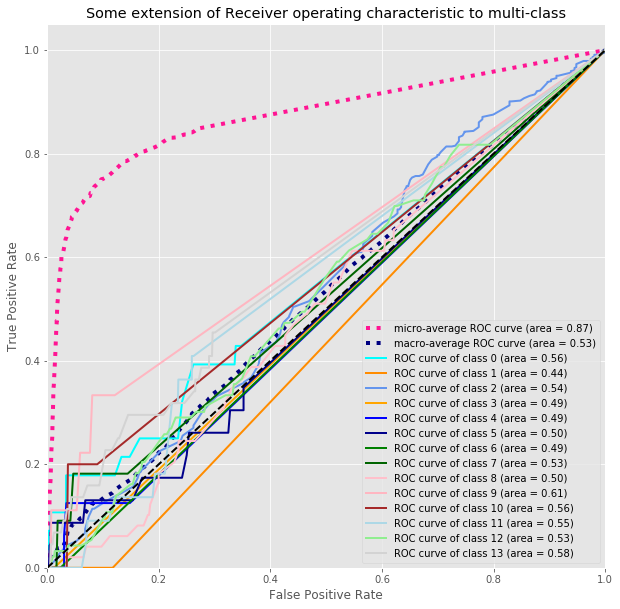

In [44]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(domain_categories))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(domain_categories)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(domain_categories)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'orange', 'blue', 'darkblue', 'green', 'darkgreen', 'pink', 'lightpink', 'brown', 'lightblue', 'lightgreen', 'lightgrey'])
for i, color in zip(range(len(domain_categories)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()